# 9: Markov Chain Monte Carlo

In [5]:
%load_ext autoreload
%autoreload 2

In [52]:
%cd "C:/msys64/home/ecotner/statistical-rethinking/"

C:\msys64\home\ecotner\statistical-rethinking


In [104]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.tensor as tt
import pyro
from pyro.distributions import Normal, Exponential
from pyro.infer.mcmc import NUTS, MCMC

sys.path.insert(0, "C:/msys64/home/ecotner/statistical-rethinking/code")
from models import RegressionBase
from utils import precis, sample_posterior

### Code 9.1
Simple simulation to reproduce the "Metropolis algorithm" (not the real one, the simplified one from the story about "King Markov" and his island kingdom).

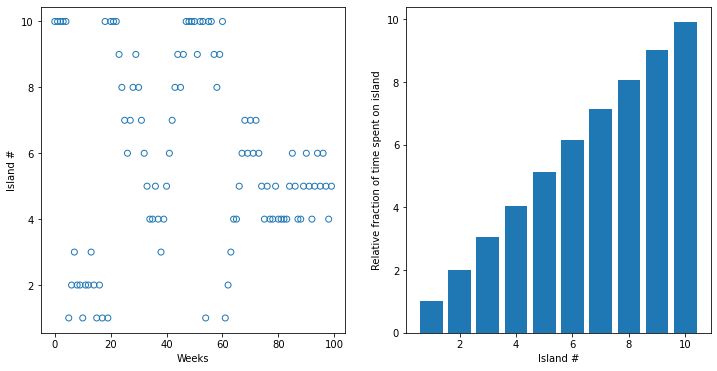

In [20]:
num_weeks = 1e5
positions = np.zeros(int(num_weeks))
current = 10
for i in range(int(num_weeks)):
    positions[i] = current
    proposal = current + np.random.choice((-1, 1))
    if proposal < 1: proposal = 10
    if proposal > 10: proposal = 1
    
    prob_move = proposal/current
    current = proposal if np.random.rand() < prob_move else current

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
# Plot the markov chain samples
plt.sca(axes[0])
plt.scatter(np.arange(100), positions[:100], facecolor="none", edgecolor="C0")
plt.xlabel("Weeks")
plt.ylabel("Island #")
# Plot relative fraction of visitation frequency
plt.sca(axes[1])
val, count = np.unique(positions, return_counts=True)
plt.bar(val, height=count/count[0])
plt.xlabel("Island #")
plt.ylabel("Relative fraction of time spent on island")
plt.show()

### Code 9.2
Illustrate how probability mass in high-dimensional distributions is not necessarily located near the mode. The multidimensional standard normal, for example, has a differential probability mass of
$$
\begin{align}
dp &\propto d^nx\, \exp(-|\vec{x}|^2/2) \\
&\propto dr\, r^{n-1} \exp(-r^2/2)
\end{align}
$$
The radial probability density is proportional to $r^{n-1} \exp(-r^2/2)$, which we can see peaks further away from the mode of the distribution ($r=0$) the greater the dimension $n$.

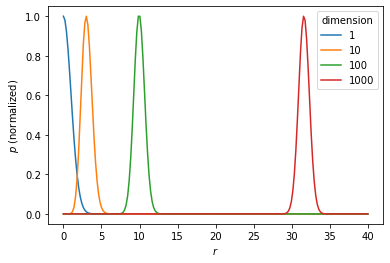

In [39]:
r = np.linspace(1e-3, 40, 200)
for n in (1, 10, 100, 1000):
    # calculate the log of the density first for numerical stability
    logp = (n-1)*np.log(r) - r**2/2
    p = np.exp(logp - logp.max())
    p /= p.max() # normalize to max
    plt.plot(r, p, label=n)
plt.xlabel("$r$")
plt.ylabel("$p$ (normalized)")
plt.legend(title="dimension")
plt.show()

We can sample from a random normal distribution too and show that the distribution of samples matches the theoretical estimate

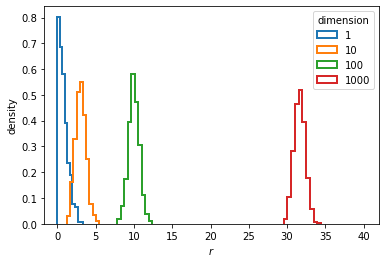

In [51]:
for n in (1, 10, 100, 1000):
    s = np.random.randn(n, 1000) # sample
    s = np.sqrt(np.square(s).sum(axis=0)) # dist from center
    plt.hist(s, density=True, histtype="step", linewidth=2, label=n)
plt.xlim(right=42)
plt.xlabel("$r$")
plt.ylabel("density")
plt.legend(title="dimension", loc="upper right")
plt.show()

### Code 9.3 - 9.?
Let's code up an HMC algorithm for fitting a simple Gaussian. We will need a couple pieces. First off is the "potential energy" function $U$, which is simply the negative log-likelihood of the model: $U(\theta) = -\ln L(\theta;X)$.

In [ ]:
def U(q, a=0, b=1, k=0, d=1):
    muy = q[1]
    mux = q[2]
    _U = 

### Code 9.9 - 9.16
Now let's test out some HMC. I don't have access to the `ulam` function McElreath uses, so I'll just use `pyro`'s built-in NUTS kernel.

In [53]:
rugged_df = pd.read_csv("data/rugged.csv", sep=";")
rugged_df.head()

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,africa_region_w,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent
0,ABW,533,Aruba,0.462,0.380,1.226,0.144,0.000,18.0,12.508,...,0,0,0,0.0,NaN,NaN,NaN,NaN,614.0,NaN
1,AFG,4,Afghanistan,2.518,1.469,7.414,0.720,39.004,65209.0,33.833,...,0,0,0,0.0,NaN,NaN,NaN,NaN,1870829.0,0.0
2,AGO,24,Angola,0.858,0.714,2.274,0.228,4.906,124670.0,-12.299,...,0,0,1,3610000.0,5.669,6.981,4.926,3.872,1223208.0,2.0
3,AIA,660,Anguilla,0.013,0.010,0.026,0.006,0.000,9.0,18.231,...,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,ALB,8,Albania,3.427,1.597,10.451,1.006,62.133,2740.0,41.143,...,0,0,0,0.0,NaN,NaN,NaN,NaN,200000.0,100.0


In [61]:
d = rugged_df.assign(log_gdp=np.log(rugged_df["rgdppc_2000"]))
dd = d[~d["log_gdp"].isna()].copy()
dd["log_gdp_std"] = dd["log_gdp"] / dd["log_gdp"].mean()
dd["rugged_std"] = dd["rugged"] / dd["rugged"].max()
dd["cid"] = dd["cont_africa"].astype(int)

Let's first fit the model using our Gaussian approximation

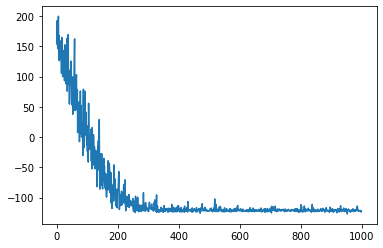

In [67]:
class M8_5(RegressionBase):
    def __call__(self, data=None):
        a = pyro.sample("a", Normal(1., 0.1).expand([2]).to_event(0))
        b = pyro.sample("b", Normal(0., 0.3).expand([2]).to_event(0))
        sigma = pyro.sample("sigma", Exponential(1.))
        if data is None:
            A = self.cid
            mu = a[A] + b[A] * (self.rugged_std - 0.215)
            pyro.sample("log_gdp_std", Normal(mu, sigma), obs=self.log_gdp_std)
        else:
            A = data["cid"]
            mu = a[A] + b[A] * (data["rugged_std"] - 0.215)
            return pyro.sample("log_gdp_std", Normal(mu, sigma))
            
m8_5 = M8_5(dd[["log_gdp_std", "rugged_std", "cid"]], categoricals=("cid",))
loss = m8_5.train(1000)
plt.plot(loss); plt.show()

In [72]:
samples = {"m8.5": sample_posterior(m8_5, 1000, ("a", "b", "sigma"))}
s = samples["m8.5"]
for var in ("a", "b"):
    for i in (0, 1):
        s[f"{var}[{i}]"] = s[var][:,i]
    del s[var]
precis(s)

,mean,stddev,5.5%,94.5%
sigma,0.113218,0.00709692,0.101986,0.124521
a[0],1.05277,0.0103692,1.03667,1.06925
a[1],0.865308,0.019816,0.833713,0.895805
b[0],-0.148361,0.0654062,-0.253086,-0.0438378
b[1],0.174698,0.0760501,0.0546369,0.297161


Now we can use NUTS to perform inference:

In [131]:
# Define the model; no guide needed
torch.multiprocessing.set_sharing_strategy("file_system")
class M9_1:
    def __init__(self, df, categoricals=None):
        if categoricals is None:
            categoricals = []
        for col in set(df.columns) - set(categoricals):
            setattr(self, col, tt(df[col].values).double())
        for col in categoricals:
            setattr(self, col, tt(df[col].values).long())
    
    def model(self, data=None):
        a = pyro.sample("a", Normal(1., 0.1).expand([2]).to_event(0))
        b = pyro.sample("b", Normal(0., 0.3).expand([2]).to_event(0))
        sigma = pyro.sample("sigma", Exponential(1.))
        if data is None:
            A = self.cid
            mu = a[A] + b[A] * (self.rugged_std - 0.215)
            pyro.sample("log_gdp_std", Normal(mu, sigma), obs=self.log_gdp_std)
        else:
            A = data["cid"]
            mu = a[A] + b[A] * (data["rugged_std"] - 0.215)
            return pyro.sample("log_gdp_std", Normal(mu, sigma))
        
    def train(self, num_warmup, num_samples, num_chains=1):
        # apparently multiple chains does not work on windows; I should switch over to 
        # my ubuntu partition and try it out later
        kernel = NUTS(self.model, adapt_step_size=True, adapt_mass_matrix=True, jit_compile=True)
        self.engine = MCMC(kernel, num_samples, num_warmup, num_chains=num_chains)
        self.engine.run()

In [132]:
m9_1 = M9_1(dd[["log_gdp_std", "rugged_std", "cid"]], categoricals=("cid",))
m9_1.train(1000, 1000, 2)

Warmup [2]:   0%|          | 0/2000 [00:00, ?it/s]




TypeError: can't pickle module objects

In [135]:
import pickle

def pickle_trick(obj, max_depth=10):
    output = {}

    if max_depth <= 0:
        return output

    try:
        pickle.dumps(obj)
    except (pickle.PicklingError, TypeError, AttributeError) as e:
        failing_children = []

        if hasattr(obj, "__dict__"):
            for k, v in obj.__dict__.items():
                result = pickle_trick(v, max_depth=max_depth - 1)
                if result:
                    failing_children.append(result)

        output = {
            "fail": obj, 
            "err": e, 
            "depth": max_depth, 
            "failing_children": failing_children
        }

    return output

In [136]:
pickle_trick(m9_1)

ModuleNotFoundError: No module named '_gdbm'

In [111]:
samples["m9.1"] = {k: v.numpy() for k, v in m9_1.engine.get_samples().items()}
s = samples["m9.1"]
for var in ("a", "b"):
    for i in (0, 1):
        s[f"{var}[{i}]"] = s[var][:,i]
    del s[var]
precis(s)

,mean,stddev,5.5%,94.5%
sigma,0.111459,0.00640731,0.101799,0.121962
a[0],1.0506,0.00926305,1.03548,1.0652
a[1],0.887081,0.0161012,0.862851,0.913769
b[0],-0.146416,0.0586425,-0.240354,-0.0521636
b[1],0.132623,0.0785958,0.0110131,0.260828


I ran the above with a single chain (i.e. chain of samples), but you can run multiple chains in parallel. It is actually more efficient if you have multiple cores. (I know in tensorflow probability, you can use your GPU to sample, and this lets you do thousands of chains in parallel with no performance hit! Don't think this is available in pytorch unfortunately).

## Code 9.17 - 9.??
Let's analyze the results of this first HMC trial.

The pyro MCMC class tries to copy Stan as much as possible, so there are some convenience utilities that allow you to easily analyze the inference at a glance that are available in both:

In [117]:
m9_1.engine.summary(prob=0.89)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      1.05      0.01      1.05      1.04      1.07   1223.55      1.00
      a[1]      0.89      0.02      0.89      0.86      0.91   1226.39      1.00
      b[0]     -0.15      0.06     -0.14     -0.24     -0.05   1399.09      1.00
      b[1]      0.13      0.08      0.13     -0.00      0.24   1255.37      1.00
     sigma      0.11      0.01      0.11      0.10      0.12   1152.52      1.00

Number of divergences: 0


We can see that even though we drew 1000 _actual_ samples, ther are over 1000 _effective_ samples! This is because NUTS is so good, that the sampler can produce sequential samples that are better than uncorrelated (i.e. the autocorrelation between samples is actually negative).

Let's visualize the correlation of the samples

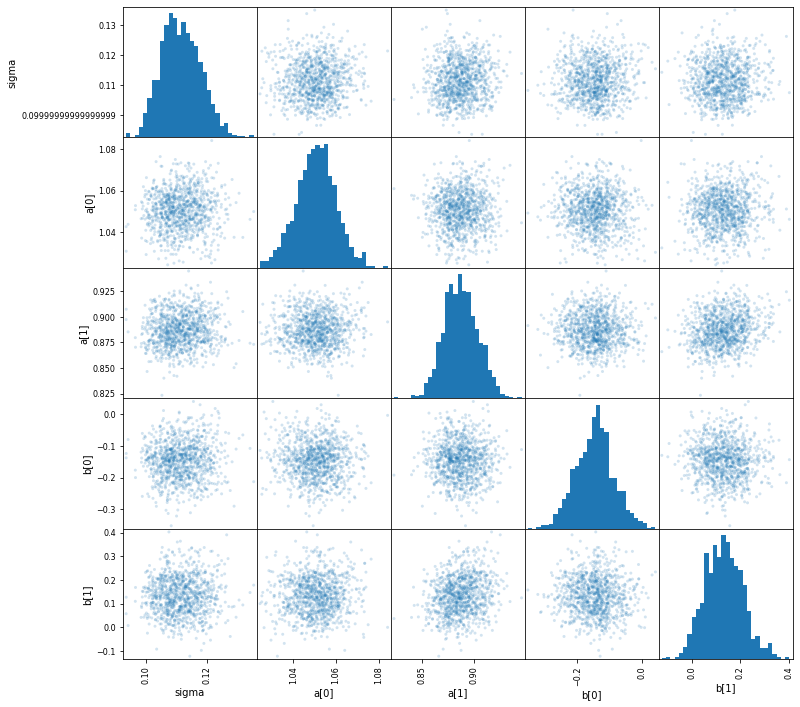

In [126]:
x = pd.DataFrame(s)
pd.plotting.scatter_matrix(x, hist_kwds={"bins": 30}, alpha=0.2, figsize=(12, 12))
plt.show()

Now let's visualize the Markov chain in sequential order. We want to check the chain for stationarity (no trend), mixing (rapid exploration of the full posterior - no slow drifting), and convergence (multiple chains stick around the same area)

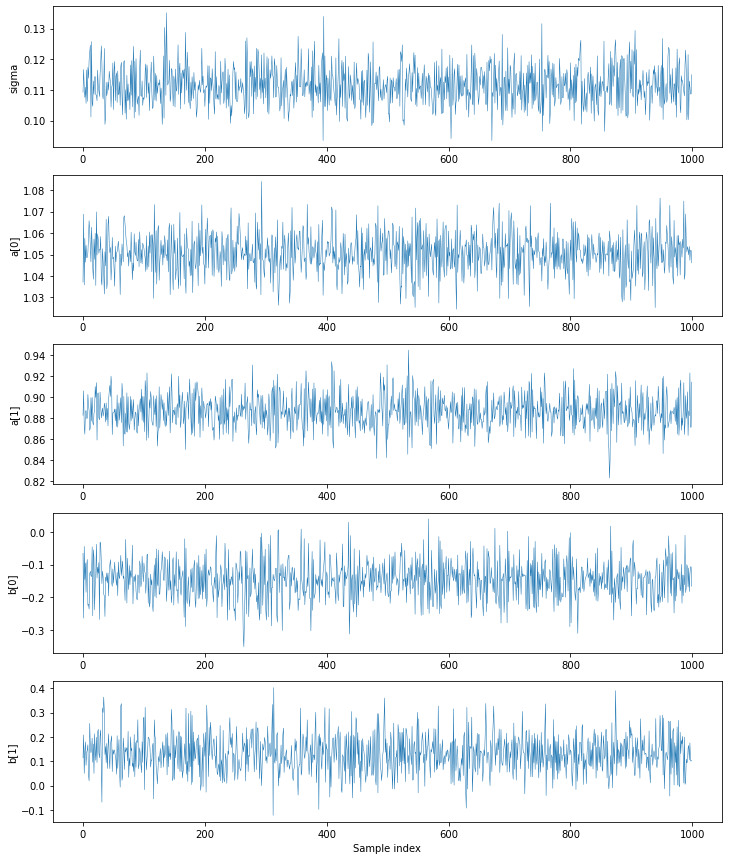

In [130]:
fig, axes = plt.subplots(nrows=len(s), figsize=(12, len(s)*3))
for (k, v), ax in zip(s.items(), axes):
    plt.sca(ax)
    plt.plot(v, linewidth=0.5)
    plt.ylabel(k)
plt.xlabel("Sample index")
plt.show()

<p style="color:red">TODO: switch over to ubuntu and try and run multiple chains, then make the trace rank plot</p>